# 1. 데이터 수집 및 전처리

## 1.1 종가/기술지표 데이터

In [ ]:
from re import M
import pandas as pd

momentum_data_url = 'https://raw.githubusercontent.com/prometheus-11team/prometheus-11team/main/store%20data/M7_stock_data_with_indicators.csv'
momentum_data = pd.read_csv(momentum_data_url)
momentum_data = momentum_data[['Date', 'Ticker', 'Close', 'ROC_10', 'RSI_14', 'MACD']]
momentum_data['Date'] = pd.to_datetime(momentum_data['Date'])
momentum_data = momentum_data[momentum_data['Date'] >= '2020-01-01']
momentum_data = momentum_data.reset_index(drop=True)
print(len(momentum_data))
display(momentum_data.tail())
data_A = momentum_data.copy()

## 1.2 거시경제 지표 데이터

In [ ]:
Macro_data_url = 'https://raw.githubusercontent.com/prometheus-11team/prometheus-11team/main/store%20data/macro_indicators_2020_2024.csv'
Macro_data = pd.read_csv(Macro_data_url)
Macro_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
Macro_data['Date'] = pd.to_datetime(Macro_data['Date'])
print(len(Macro_data))
Macro_data.tail()

64


,Date,Federal Funds Rate,10Y Treasury Yield,CPI,Core CPI,PCE Price Index,Retail Sales,Unemployment Rate,Non-Farm Payrolls,M2 Money Stock
59,2024-12-01,4.48,4.39,317.603,323.296,124.769,717662.0,4.1,158942.0,21489.9
60,2025-01-01,4.33,4.63,319.086,324.739,125.231,711461.0,4.0,159053.0,21577.0
61,2025-02-01,4.33,4.45,319.775,325.475,125.788,711680.0,4.1,159155.0,21670.5
62,2025-03-01,4.33,4.28,319.615,325.659,125.732,722025.0,4.2,159340.0,21762.5
63,2025-04-01,4.33,4.28,320.321,326.430,NaN,NaN,4.2,159517.0,NaN


###1.2-1 월간 데이터를 일간데이터로

In [ ]:
# 1. 'Date'를 인덱스로 설정
Macro_data.set_index('Date', inplace=True)

# 2. 일단위 date range 생성 (시작일 ~ 종료일 설정 필요)
daily_index = pd.date_range(start='2020-01-01', end='2025-04-30', freq='D')

# 3. 일간 인덱스로 재구성 + 최근 값으로 채우기
Macro_data_daily = Macro_data.reindex(daily_index, method='ffill')

# 4. 인덱스 다시 'Date' 컬럼으로 복원
Macro_data_daily = Macro_data_daily.reset_index().rename(columns={'index': 'Date'})

# 확인
print(len(Macro_data_daily))
Macro_data_daily.head()

1947


,Date,Federal Funds Rate,10Y Treasury Yield,CPI,Core CPI,PCE Price Index,Retail Sales,Unemployment Rate,Non-Farm Payrolls,M2 Money Stock
0,2020-01-01,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
1,2020-01-02,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
2,2020-01-03,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
3,2020-01-04,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
4,2020-01-05,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8


In [ ]:
# 주가/기술지표 + 거시경제지표
mom_macro_merged = pd.merge(momentum_data, Macro_data_daily, on='Date', how='left')
print(len(mom_macro_merged))
mom_macro_merged.head()
data_C = mom_macro_merged.copy()

9373


## 1.3 기업실적 데이터

In [ ]:
financial_data_url = 'https://raw.githubusercontent.com/prometheus-11team/prometheus-11team/main/store%20data/M7_financial_data_2020_2025.csv'
financial_data = pd.read_csv(financial_data_url)
financial_data.tail()

,Company,Fiscal Year,Period,Report Type,End Date,Operating Income,Net Income,EPS Diluted,Total Assets,Shareholders Equity,Release Date
146,Tesla,2024,Annual,10-K,2024-12-31,7076.0,7091.0,2.04,122070.0,72913.0,2025-01-30
147,Tesla,2024,Q1,10-Q,2024-03-31,1171.0,1129.0,0.34,109226.0,64378.0,2024-04-24
148,Tesla,2024,Q2,10-Q,2024-06-30,2776.0,2607.0,0.76,112832.0,66468.0,2024-07-24
149,Tesla,2024,Q3,10-Q,2024-09-30,5493.0,4774.0,1.38,119852.0,69931.0,2024-10-24
150,Tesla,2025,Q1,10-Q,2025-03-31,399.0,409.0,0.12,125111.0,74653.0,2025-04-23


### 1.3-1 월간 데이터를 일간데이터로

In [ ]:
# 회사명과 Ticker 간 매핑 딕셔너리
company_to_ticker = {
    'Alphabet': 'GOOGL',
    'Amazon': 'AMZN',
    'Apple': 'AAPL',
    'Meta': 'META',
    'Microsoft': 'MSFT',
    'Nvidia': 'NVDA',
    'Tesla': 'TSLA'
}

# 컬럼명 바꾸기: Company → Ticker
financial_data['Ticker'] = financial_data['Company'].map(company_to_ticker)

# Release Date를 Date로 복사해서 datetime 형식으로 변환
financial_data['Date'] = pd.to_datetime(financial_data['Release Date'])



In [ ]:
# 필요한 재무 피처만 선택
features = ['Operating Income', 'Net Income', 'EPS Diluted', 'Total Assets', 'Shareholders Equity']

# 시작일 ~ 종료일 범위 설정 (주가 데이터 기준)
daily_index = pd.date_range(start='2020-01-01', end='2025-04-30', freq='D')

# 결과 저장용 리스트
daily_financial_list = []

for ticker in financial_data['Ticker'].unique():
    df_t = (
        financial_data
        .loc[financial_data['Ticker'] == ticker, ['Date', 'Ticker'] + features]
        .copy()
        .set_index('Date')
        .sort_index()
    )

    # (Optional) 같은 발표일이 여러 건 있으면 최신 행만 남기기
    df_t = df_t[~df_t.index.duplicated(keep='last')]

    # 1) daily_index로 리인덱스 → 2) NaN 채우기를 ffill 로
    df_t = df_t.reindex(daily_index)
    df_t = df_t.ffill()

    # Ticker 컬럼 복원 & 인덱스 정리
    df_t['Ticker'] = ticker
    df_t = df_t.reset_index().rename(columns={'index': 'Date'})

    daily_financial_list.append(df_t)

# 4) 모든 티커 합치기
daily_financial_data = pd.concat(daily_financial_list, ignore_index=True)

# 결과 확인
print(len(daily_financial_data))
daily_financial_data.tail(10)

13629


,Date,Ticker,Operating Income,Net Income,EPS Diluted,Total Assets,Shareholders Equity
13619,2025-04-21,TSLA,7076.0,7091.0,2.04,122070.0,72913.0
13620,2025-04-22,TSLA,7076.0,7091.0,2.04,122070.0,72913.0
13621,2025-04-23,TSLA,399.0,409.0,0.12,125111.0,74653.0
13622,2025-04-24,TSLA,399.0,409.0,0.12,125111.0,74653.0
13623,2025-04-25,TSLA,399.0,409.0,0.12,125111.0,74653.0
13624,2025-04-26,TSLA,399.0,409.0,0.12,125111.0,74653.0
13625,2025-04-27,TSLA,399.0,409.0,0.12,125111.0,74653.0
13626,2025-04-28,TSLA,399.0,409.0,0.12,125111.0,74653.0
13627,2025-04-29,TSLA,399.0,409.0,0.12,125111.0,74653.0
13628,2025-04-30,TSLA,399.0,409.0,0.12,125111.0,74653.0


In [ ]:
# 주가/기술 지표 + 기업 실적 데이터
mom_fin_merged_data = pd.merge(momentum_data, daily_financial_data, on=['Date', 'Ticker'], how='left')
print(len(mom_fin_merged_data))
mom_fin_merged_data.head()
data_B = mom_fin_merged_data.copy()

9373


In [ ]:
# 종가 + 기술지표 + 실적 + 거시지표 통합
full_merged = pd.merge(mom_fin_merged_data, Macro_data_daily, on='Date', how='left')

# 확인
print(full_merged.shape)
full_merged.head()
data_D = full_merged.copy()

(9373, 20)


# Transformer 이진분류 백테스팅

In [ ]:
display(data_D.head())
data_D.columns

,Date,Ticker,Close,ROC_10,RSI_14,MACD,Operating Income,Net Income,EPS Diluted,Total Assets,Shareholders Equity,Federal Funds Rate,10Y Treasury Yield,CPI,Core CPI,PCE Price Index,Retail Sales,Unemployment Rate,Non-Farm Payrolls,M2 Money Stock
0,2020-01-02,AAPL,72.716064,NaN,NaN,0.063445,NaN,NaN,NaN,NaN,NaN,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
1,2020-01-03,AAPL,72.009117,NaN,NaN,0.180237,NaN,NaN,NaN,NaN,NaN,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
2,2020-01-06,AAPL,72.582909,NaN,NaN,0.315050,NaN,NaN,NaN,NaN,NaN,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
3,2020-01-07,AAPL,72.241547,NaN,NaN,0.510256,NaN,NaN,NaN,NaN,NaN,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8
4,2020-01-08,AAPL,73.403633,NaN,NaN,0.780123,NaN,NaN,NaN,NaN,NaN,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8


Index(['Date', 'Ticker', 'Close', 'ROC_10', 'RSI_14', 'MACD',
       'Operating Income', 'Net Income', 'EPS Diluted', 'Total Assets',
       'Shareholders Equity', 'Federal Funds Rate', '10Y Treasury Yield',
       'CPI', 'Core CPI', 'PCE Price Index', 'Retail Sales',
       'Unemployment Rate', 'Non-Farm Payrolls', 'M2 Money Stock'],
      dtype='object')

### 타겟 레이블 생성 & NaN 제거

In [ ]:
# 1) 원본 복사
df = data_D.copy()

# 2) Date 타입 보장
df['Date'] = pd.to_datetime(df['Date'])

# 3) Target 생성: 다음 5일 수익률 > 0 → 1, else 0
df['Signal'] = ((df['Close'].shift(-5) / df['Close']) - 1 > 0).astype(int)

# 4) 마지막 5일간은 Target이 NaN 이므로 제거
df = df.dropna(subset=['Signal']).reset_index(drop=True)

# 5) 피처에 남아있는 NaN 행도 제거 (기업실적·거시지표 ffill 과정 중 남은 NaN 방지)
df = df.dropna().reset_index(drop=True)

# 6) 컬럼 확인
print(df[['Date','Ticker','Close','Signal']].head(10))
print(f"총 {len(df)}개의 유효 샘플이 남았습니다.")
df.head(10)

        Date Ticker      Close  Signal
0 2020-01-29   AAPL  78.524147       0
1 2020-01-30   AAPL  78.410362       1
2 2020-01-31   AAPL  74.933746       1
3 2020-02-03   AAPL  74.727951       1
4 2020-02-04   AAPL  77.195023       1
5 2020-02-05   AAPL  77.824493       1
6 2020-02-06   AAPL  78.734795       1
7 2020-02-07   AAPL  77.664574       1
8 2020-02-10   AAPL  78.033440       0
9 2020-02-11   AAPL  77.562622       1
총 7569개의 유효 샘플이 남았습니다.


,Date,Ticker,Close,ROC_10,RSI_14,MACD,Operating Income,Net Income,EPS Diluted,Total Assets,...,Federal Funds Rate,10Y Treasury Yield,CPI,Core CPI,PCE Price Index,Retail Sales,Unemployment Rate,Non-Farm Payrolls,M2 Money Stock,Signal
0,2020-01-29,AAPL,78.524147,3.729051,68.465096,2.447425,25569.0,22236.0,4.99,340618.0,...,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8,0
1,2020-01-30,AAPL,78.410362,4.024551,63.879072,2.782423,25569.0,22236.0,4.99,340618.0,...,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8,1
2,2020-01-31,AAPL,74.933746,-1.817655,49.368823,3.065082,25569.0,22236.0,4.99,340618.0,...,1.55,1.76,259.127,266.716,104.419,515119.0,3.6,152031.0,15416.8,1
3,2020-02-03,AAPL,74.727951,-3.159419,42.987458,3.939935,25569.0,22236.0,4.99,340618.0,...,1.58,1.50,259.250,267.370,104.541,515330.0,3.5,152292.0,15467.0,1
4,2020-02-04,AAPL,77.195023,0.720235,54.739665,5.149822,25569.0,22236.0,4.99,340618.0,...,1.58,1.50,259.250,267.370,104.541,515330.0,3.5,152292.0,15467.0,1
5,2020-02-05,AAPL,77.824493,1.180397,57.618768,5.228780,25569.0,22236.0,4.99,340618.0,...,1.58,1.50,259.250,267.370,104.541,515330.0,3.5,152292.0,15467.0,1
6,2020-02-06,AAPL,78.734795,1.873247,57.529106,5.306891,25569.0,22236.0,4.99,340618.0,...,1.58,1.50,259.250,267.370,104.541,515330.0,3.5,152292.0,15467.0,1
7,2020-02-07,AAPL,77.664574,0.778965,51.533761,5.302879,25569.0,22236.0,4.99,340618.0,...,1.58,1.50,259.250,267.370,104.541,515330.0,3.5,152292.0,15467.0,1
8,2020-02-10,AAPL,78.033440,4.325340,54.317836,5.362737,25569.0,22236.0,4.99,340618.0,...,1.58,1.50,259.250,267.370,104.541,515330.0,3.5,152292.0,15467.0,0
9,2020-02-11,AAPL,77.562622,0.843116,51.981963,5.365008,25569.0,22236.0,4.99,340618.0,...,1.58,1.50,259.250,267.370,104.541,515330.0,3.5,152292.0,15467.0,1


### ① 정규화 → ② 시계열 Train/Test 분할 과, 그 다음 ③ 윈도우 생성 → ④ 분류 모델 학습/예측 → ⑤ 백테스트 신호 부착

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# (2) Train/Test 시계열 분할 (날짜로)
split_date = '2024-01-01'
train_df = df[df['Date'] < split_date].copy().reset_index(drop=True)
test_df  = df[df['Date'] >= split_date].copy().reset_index(drop=True)

# ───────────────────────────────────────────────────────────────
# (3) 피처 정규화 (train 기준으로 fit → test 에 transform)
feature_cols = [c for c in train_df.columns
                if c not in ['Date','Ticker','Close','Signal','Proba']]

scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

# ───────────────────────────────────────────────────────────────
# (4) 시계열 윈도우 생성 함수
def create_sequence(df, window=30):
    X, y, date_ticker_pairs = [], [], []
    vals   = df[feature_cols].values
    sigs   = df['Signal'].values
    dates  = df['Date'].values
    ticks  = df['Ticker'].values

    for i in range(len(df) - window):
        X.append(vals[i:i+window])
        y.append(sigs[i+window])
        # 나중에 날짜·종목 추적용
        date_ticker_pairs.append((dates[i+window], ticks[i+window]))
    return np.array(X), np.array(y), date_ticker_pairs

X_train, y_train, _     = create_sequence(train_df, window=30)
X_test,  y_test,  test_meta = create_sequence(test_df,  window=30)

# ───────────────────────────────────────────────────────────────
# (5) Transformer 분류 모델 (sketch)
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class TransformerClassifier(nn.Module):
    def __init__(self,input_dim,d_model=64,nhead=4, layers=2):
        super().__init__()
        self.embed = nn.Linear(input_dim,d_model)
        enc = nn.TransformerEncoderLayer(d_model,nhead,batch_first=True)
        self.encoder = nn.TransformerEncoder(enc,layers)
        self.head = nn.Linear(d_model,1)
    def forward(self,x):
        x = self.embed(x)
        x = self.encoder(x)
        return torch.sigmoid(self.head(x[:,-1]))  # (B,1)

# ───────────────────────────────────────────────────────────────
# (6) 학습 루프
# def train_cls(X,y,epochs=10,bs=32,lr=1e-3):
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     X_t = torch.tensor(X,dtype=torch.float32).to(device)
#     y_t = torch.tensor(y,dtype=torch.float32).view(-1,1).to(device)
#     ds = TensorDataset(X_t,y_t)
#     ld = DataLoader(ds,batch_size=bs,shuffle=True)

#     model = TransformerClassifier(X.shape[2]).to(device)
#     opt   = torch.optim.Adam(model.parameters(),lr=lr)
#     loss_fn = nn.BCELoss()

#     model.train()
#     for ep in range(1,epochs+1):
#         losses=[]
#         for xb,yb in ld:
#             opt.zero_grad()
#             p = model(xb)
#             loss = loss_fn(p,yb)
#             loss.backward(); opt.step()
#             losses.append(loss.item())
#         print(f"Epoch {ep} | Loss {np.mean(losses):.4f}")
#     return model

import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

def train_cls_with_val(
    X, y,
    epochs=50,
    bs=32,
    lr=1e-3,
    val_ratio=0.2,
    device=None
):
    # 1) 장치 설정
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    # 2) 전체 데이터 → TensorDataset
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32).view(-1,1)
    ds  = TensorDataset(X_t, y_t)

    # 3) train/val 분할
    n_val = int(len(ds) * val_ratio)
    n_trn = len(ds) - n_val
    trn_ds, val_ds = random_split(ds, [n_trn, n_val])

    trn_loader = DataLoader(trn_ds, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False)

    # 4) 모델·최적화·손실함수
    model   = TransformerClassifier(input_dim=X.shape[2]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn   = nn.BCELoss()

    # 5) 학습 루프
    for ep in range(1, epochs+1):
        # — train
        model.train()
        trn_losses = []
        for xb, yb in trn_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss  = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            trn_losses.append(loss.item())

        # — validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss  = loss_fn(preds, yb)
                val_losses.append(loss.item())

        # — 에포크별 출력
        print(
            f"Epoch {ep:02d} | "
            f"Train Loss: {np.mean(trn_losses):.4f} | "
            f"Val Loss:   {np.mean(val_losses):.4f}"
        )

    return model


In [ ]:
model = train_cls_with_val(X_train,y_train,epochs=50)

Epoch 01 | Train Loss: 0.6924 | Val Loss:   0.6784
Epoch 02 | Train Loss: 0.6712 | Val Loss:   0.6673
Epoch 03 | Train Loss: 0.6619 | Val Loss:   0.6594
Epoch 04 | Train Loss: 0.6465 | Val Loss:   0.6346
Epoch 05 | Train Loss: 0.6354 | Val Loss:   0.6459
Epoch 06 | Train Loss: 0.6242 | Val Loss:   0.6388
Epoch 07 | Train Loss: 0.6173 | Val Loss:   0.6643
Epoch 08 | Train Loss: 0.6176 | Val Loss:   0.6562
Epoch 09 | Train Loss: 0.5963 | Val Loss:   0.6005
Epoch 10 | Train Loss: 0.5882 | Val Loss:   0.6342
Epoch 11 | Train Loss: 0.5830 | Val Loss:   0.5861
Epoch 12 | Train Loss: 0.5696 | Val Loss:   0.5927
Epoch 13 | Train Loss: 0.5522 | Val Loss:   0.5774
Epoch 14 | Train Loss: 0.5476 | Val Loss:   0.6146
Epoch 15 | Train Loss: 0.5519 | Val Loss:   0.5741
Epoch 16 | Train Loss: 0.5380 | Val Loss:   0.5831
Epoch 17 | Train Loss: 0.5391 | Val Loss:   0.5634
Epoch 18 | Train Loss: 0.5278 | Val Loss:   0.6088
Epoch 19 | Train Loss: 0.5348 | Val Loss:   0.5869
Epoch 20 | Train Loss: 0.5163 |

In [ ]:
# ───────────────────────────────────────────────────────────────
# (7) 테스트 예측 & Signal 부착
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.eval()
X_t = torch.tensor(X_test,dtype=torch.float32).to(device)
with torch.no_grad():
    probs = model(X_t).cpu().numpy().flatten()
preds = (probs > 0.5).astype(int)

# 테스트 DataFrame에 날짜·티커 매핑
test_dates = [d for d,_ in test_meta]
test_ticks = [t for _,t in test_meta]
signal_df = pd.DataFrame({
    'Date': test_dates,
    'Ticker': test_ticks,
    'Signal': preds,
    'Proba':  probs
})

print(signal_df.head())

        Date Ticker  Signal     Proba
0 2024-02-14   AAPL       0  0.388963
1 2024-02-15   AAPL       0  0.413876
2 2024-02-16   AAPL       0  0.394572
3 2024-02-20   AAPL       0  0.475812
4 2024-02-21   AAPL       0  0.414300


### 진입가·청산가 계산 → 개별 트레이드 수익률 → 일별·포트폴리오 수익률 집계

=== 백테스트 결과 ===
기간 수익률    : 75.13%
연환산 수익률 : 58.40%
샤프 비율     : 1.43
최대 낙폭     : 72.18%


/tmp/ipython-input-27-370251902.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.assign(


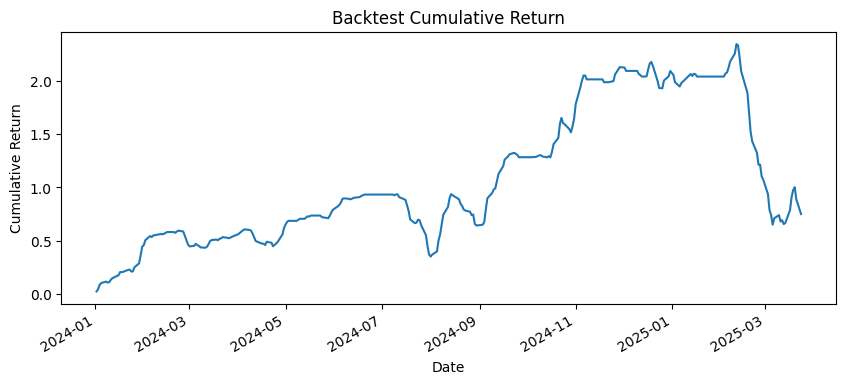

In [ ]:
# 1) test_df 에 예측 신호 붙이기
test_df = test_df.copy()

# signal_df 의 Signal → Pred 로 이름 바꾼 뒤
signal_df_renamed = signal_df[['Date','Ticker','Signal','Proba']].rename(
    columns={'Signal':'Pred', 'Proba':'Proba_pred'}
)

test_df = test_df.merge(
    signal_df_renamed,
    on=['Date','Ticker'],
    how='left'
)

# merge 결과 Pred_x, Pred_y 로 나뉘었다면
if 'Pred_y' in test_df.columns:
    # 새로 붙인 Pred_y를 Pred 로 복사
    test_df['Pred'] = test_df['Pred_y']
    # 오래된 Pred_x, Pred_y 컬럼 삭제
    test_df.drop(['Pred_x','Pred_y'], axis=1, inplace=True)

# NaN은 예측 불가 구간 → 0(관망)
test_df['Signal'] = test_df['Pred'].fillna(0).astype(int)

# 2) 진입가/청산가 계산
test_df = (
    test_df
    .sort_values(['Ticker','Date'])
    .groupby('Ticker')
    .apply(lambda d: d.assign(
        entry_price = d['Close'].shift(-1),
        exit_price  = d['Close'].shift(-5)
    ))
    .reset_index(drop=True)
)

# 3) 개별 트레이드 수익률
test_df['trade_return'] = np.where(
    test_df['Signal']==1,
    test_df['exit_price'] / test_df['entry_price'] - 1,
    0.0
)

# 4) 일별 포트폴리오 리턴 집계
daily = (
    test_df
    .dropna(subset=['entry_price','exit_price'])
    .groupby('Date')['trade_return']
    .mean()
    .rename('daily_return')
)

# 5) 누적수익률 및 성과지표
cum_return   = (1 + daily).cumprod() - 1
total_return = cum_return.iloc[-1]
annual_return= (1+total_return)**(252/len(cum_return)) - 1
sharpe       = daily.mean() / daily.std() * np.sqrt(252)
drawdown     = (cum_return.cummax() - cum_return) / cum_return.cummax()
max_dd       = drawdown.max()

print("=== 백테스트 결과 ===")
print(f"기간 수익률    : {total_return:.2%}")
print(f"연환산 수익률 : {annual_return:.2%}")
print(f"샤프 비율     : {sharpe:.2f}")
print(f"최대 낙폭     : {max_dd:.2%}")

# 6) 누적수익률 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
cum_return.plot(title="Backtest Cumulative Return")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()


In [ ]:
from google.colab import drive
import os
import torch

# 1) Drive 마운트
drive.mount('/content/drive')

# 2) 저장 경로 준비
save_dir = '/content/drive/MyDrive/transformer_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'transformer_classifier_best.pt')

# 3) 모델 저장 (state_dict 방식)
torch.save(model.state_dict(), save_path)
print(f"✅ 모델을 {save_path} 에 저장했습니다.")


Mounted at /content/drive
✅ 모델을 /content/drive/MyDrive/transformer_models/transformer_classifier_best.pt 에 저장했습니다.
